In [1]:
%matplotlib inline

In [2]:
import math 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy.optimize import brentq

import cvxpy as cp

from tqdm.notebook import trange

In [3]:
from rsnn.spike_train.generator import PeriodicSpikeTrainGenerator
from rsnn.spike_train.spike_train import SpikeTrain
from rsnn.spike_train.periodic_spike_train import MultiChannelPeriodicSpikeTrain
from rsnn.rsnn.neuron import Neuron
from rsnn.spike_train.measure import single_channel_correlation

/Users/haguettaz/Documents/RSNN/src/rsnn/spike_train/generator.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [4]:
plt.style.use('scientific')

In [5]:
rng = np.random.default_rng(7)

# Supervised Learning for Spiking Neurons

In [97]:
num_inputs = 250 # number of synapses
delays = rng.uniform(1.0, 20.0, num_inputs)
synapse_decay, soma_decay = 4, 5
firing_threshold = 1.0
wmin, wmax = -0.1, 0.1

period = 100.0
firing_rate, rel_refractory_period, abs_refractory_period = 0.1, 5.0, 5.0
refractory_weight = 1

In [98]:
times = np.linspace(0, period, 10000)

In [99]:
def input_spike_resp(t):
    tmax = (math.log(synapse_decay) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_decay)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_decay))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_decay))
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / soma_decay) - np.exp(-t / synapse_decay))

def input_spike_resp_deriv(t):
    tmax = (math.log(synapse_decay) - math.log(soma_decay)) / (1 / soma_decay - 1 / synapse_decay)
    gamma = 1 / (math.exp(-tmax / soma_decay) - math.exp(-tmax / synapse_decay))

    if isinstance(t, np.ndarray):
        z = gamma * (np.exp(-t / synapse_decay) / synapse_decay - np.exp(-t / soma_decay) / soma_decay)
        z[t < 0] = 0.0
        return z
    
    if t < 0:
        return 0.0
    
    return gamma * (np.exp(-t / synapse_decay) / synapse_decay - np.exp(-t / soma_decay) / soma_decay)

def refractory_spike_resp(t):
    if isinstance(t, np.ndarray):
        z = -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = -np.inf
        z[t <= 0] = 0.0
        return z
    
    if t <= 0:
        return 0.0
    
    if t <= abs_refractory_period:
        return -np.inf
    
    return -refractory_weight * np.exp(- (t - abs_refractory_period) / soma_decay)

def refractory_spike_resp_deriv(t):
    if isinstance(t, np.ndarray):
        z = refractory_weight / soma_decay * np.exp(- (t - abs_refractory_period) / soma_decay)
        z[t <= abs_refractory_period] = 0.0
        return z

    if t <= abs_refractory_period:
        return 0.0
    
    return refractory_weight / soma_decay * np.exp(- (t - abs_refractory_period) / soma_decay)

In [100]:
def potential(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
            ])
            return weights@y
        
        y = np.array([
            np.sum(input_spike_resp((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
        ])
        return weights@y  
        
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
        ])
        return weights@y
    
    y = np.array([
        np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
    ])
    return weights@y  

def potential_deriv(t, delays, weights, input_spike_trains, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo:
            y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])%period), axis=0) for k in range(num_inputs)
                ])
            return weights@y
        
        y = np.array([
                np.sum(input_spike_resp_deriv((t[None,:] - delays[k] - input_spike_trains.spike_trains[k].firing_times[:,None])), axis=0) for k in range(num_inputs)
            ])
        return weights@y
    
    if modulo:
        y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)%period), axis=0) for k in range(num_inputs)
            ])
        return weights@y  
    
    y = np.array([
            np.sum(input_spike_resp((t - delays[k] - input_spike_trains.spike_trains[k].firing_times)), axis=0) for k in range(num_inputs)
        ])
    return weights@y

def threshold(t, target_spike_train, modulo=True):
    if isinstance(t, np.ndarray):
        if modulo: 
            return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])%period), axis=0)

        return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
    
    if modulo: 
        return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)%period), axis=0)        
    return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times)), axis=0)

In [101]:
#def threshold(t, target_spike_train, modulo=True):
#    if isinstance(t, np.ndarray):
#        if modulo: 
#            return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])%period), axis=0)
#
#        return firing_threshold - np.sum(refractory_spike_resp((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
#    
#    if modulo: 
#        return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times[:,None])%period), axis=0)        
#    return firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times[:,None])), axis=0)

In [102]:
#def threshold_deriv(t, target_spike_train):
#    if isinstance(t, np.ndarray):
#        return - np.sum(refractory_spike_resp_deriv((t[None,:] - target_spike_train.firing_times[:,None])), axis=0)
#    return - np.sum(refractory_spike_resp_deriv((t - target_spike_train.firing_times[:,None])), axis=0)

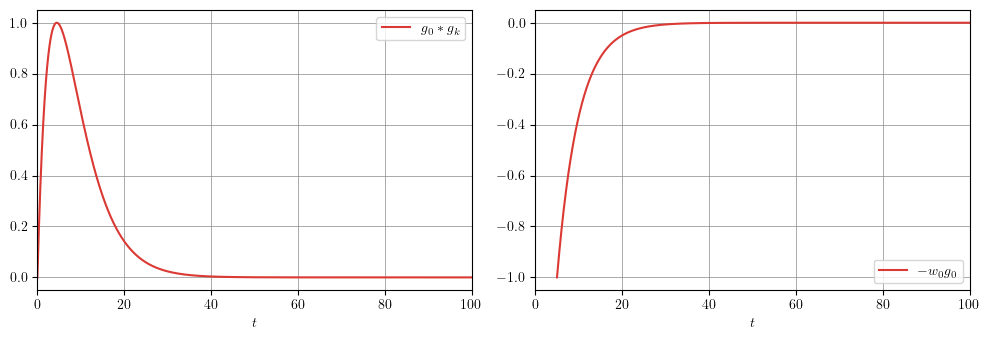

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].plot(times, input_spike_resp(times), c="C1", label=r"$g_0 * g_k$")
axes[1].plot(times, refractory_spike_resp(times), c="C1", label=r"$-w_0 g_0$")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$t$")
axes[0].set_xlim(0, period)
axes[1].set_xlabel(r"$t$")
axes[1].set_xlim(0, period)
fig.tight_layout()

In [104]:
spike_train_generator = PeriodicSpikeTrainGenerator(firing_rate, abs_refractory_period, rel_refractory_period)

In [105]:
input_spike_trains = spike_train_generator.rand(period, num_inputs)
#input_spike_train = spike_train_generator.rand(period)
#input_spike_trains = MultiChannelPeriodicSpikeTrain(
#    period, 
#    num_inputs,
#    [input_spike_train.firing_times]*num_inputs
#)
target_spike_train = spike_train_generator.rand(period)

Multi-channel periodic spike train sampling:   0%|          | 0/250 [00:00<?, ?it/s]

In [106]:
num_spikes = np.array([spike_train.num_spikes for spike_train in input_spike_trains.spike_trains])

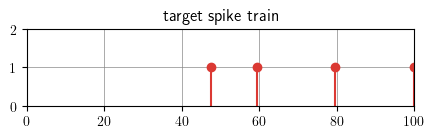

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.stem(target_spike_train.firing_times, np.ones_like(target_spike_train.firing_times), basefmt=" ", markerfmt="C1o", linefmt="C1-")
ax.set_xlim(0, period)
ax.set_ylim(0, 2)
ax.set_title("target spike train")
plt.show()

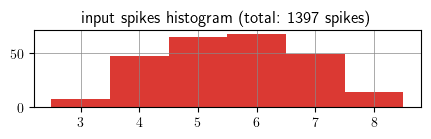

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.hist(num_spikes, bins=np.arange(np.min(num_spikes)-0.5, np.max(num_spikes)+1.5), color="C1")
ax.set_title(f"input spikes histogram (total: {np.sum(num_spikes)} spikes)")
ax.set_xticks(np.arange(np.min(num_spikes), np.max(num_spikes)+1))
plt.show()

# Computing Weights

In [122]:
def compute_spike_train(weights):
    spike_train = target_spike_train.copy()
    
    fun = lambda t_: potential(t_, delays, weights, input_spike_trains) - threshold(t_, spike_train, modulo=False)

    ta = spike_train.firing_times[-1] + abs_refractory_period
    while(ta < 2*period):
        tb = ta + 1
        if fun(ta) * fun(tb) <= 0:
            t = brentq(fun, ta, tb)
            spike_train.append(t)
            ta += abs_refractory_period
        else:
            ta += 1

    return spike_train

In [123]:
times = np.arange(period)

extended_firing_times = np.concatenate([
    target_spike_train.firing_times - period,
    target_spike_train.firing_times,
    target_spike_train.firing_times + period
])

time_diff = times[:,None] - extended_firing_times[None,:]

mask_slope = np.any(np.abs(time_diff) < 1.0, axis=1)
t_slope = times[mask_slope]
y_slope = np.stack(
    [np.sum(
        input_spike_resp_deriv(
            (t_slope[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_slope = np.full_like(t_slope, 0.5)

mask_maxlevel_f = np.any((time_diff > -1.0) & (time_diff < 0.0), axis=1)
t_maxlevel_f = times[mask_maxlevel_f]
y_maxlevel_f = np.stack(
    [np.sum(
        input_spike_resp(
            (t_maxlevel_f[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_maxlevel_f = firing_threshold - np.sum(
    refractory_spike_resp(
        (t_maxlevel_f[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

mask_maxlevel = np.all((time_diff > abs_refractory_period) | (time_diff < -1.0), axis=1)
t_maxlevel = times[mask_maxlevel]
y_maxlevel = np.stack(
    [np.sum(
        input_spike_resp(
            (t_maxlevel[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_maxlevel_f = 0.0 - np.sum(
    refractory_spike_resp(
        (t_maxlevel[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

y_firing = np.stack(
    [np.sum(
        input_spike_resp(
            (target_spike_train.firing_times[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_firing = firing_threshold - np.sum(
    refractory_spike_resp(
        (target_spike_train.firing_times[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

In [124]:
def compute_template(max_level, firing_region, min_slope):
    # to adapt for continuous-time guarantee    
    yf, ys, yl = [], [], []
    zf, zs, zl = [], [], []
    
    # equality at firing times
    # for t in target_spike_train.firing_times:
    #     yf.append(
    #         np.array(
    #             [np.sum(input_spike_resp(
    #                 (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
    #             ))
    #             for k in range(num_inputs)] 
    #         )
    #     )
    #     zf.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    yf = np.stack(
    [np.sum(input_spike_resp(
         (target_spike_train.firing_times[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
     ), axis=1)
     for k in range(num_inputs)], 
    axis=1)
    zf = firing_threshold - np.sum(refractory_spike_resp(
        (target_spike_train.firing_times[:,None] - target_spike_train.firing_times[None,:]) % period),
                                   axis=1
                                  )
        
    # smaller than the firing threshold everywhere (except during the absolute refractory period)
    #for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, 0):
    #    yl.append(
    #            np.array(
    #                [np.sum(input_spike_resp(
    #                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
    #                ))
    #                for k in range(num_inputs)] 
    #            )
    #        )
    #    zl.append(firing_threshold - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
    
        
        
    # smaller than the maximum level not close to firing (except during the absolute refractory period)
    #for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, abs_refractory_period, complement=True):
    #    yl.append(
    #            np.array(
    #                [np.sum(input_spike_resp(
    #                    (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
    #                ))
    #                for k in range(num_inputs)] 
    #            )
    #        )
    #    zl.append(max_level - np.sum(refractory_spike_resp((t - target_spike_train.firing_times) % period)))
        
    
        
    # slope larger than the minimum slope close to firing
    #for t in cyclic_neighborhood(target_spike_train.firing_times, period, firing_region, firing_region):
    #    ys.append(
    #        np.array(
    #            [np.sum(input_spike_resp_deriv(
    #                (t - delays[k] - input_spike_trains.spike_trains[k].firing_times) % period
    #            ))
    #            for k in range(num_inputs)] 
    #        )
    #    )
    #    zs.append(min_slope)
        
    #return np.vstack(yf), np.array(zf), np.vstack(yl), np.array(zl), np.vstack(ys), np.array(zs) 

In [125]:
delays = rng.uniform(1.0, 60.0, num_inputs)
#yf, zf, yl, zl, ys, zs = compute_template(firing_threshold - 0.5, 1.0, 0.5)

## Bounded Weights

In [134]:
extended_firing_times = np.concatenate([
    target_spike_train.firing_times - period,
    target_spike_train.firing_times,
    target_spike_train.firing_times + period
])

times = np.arange(0, period, 1e-2)
time_diff = times[:,None] - extended_firing_times[None,:]
mask_slope = np.any(np.abs(time_diff) < 1.0, axis=1)
t_slope = times[mask_slope]
y_slope = np.stack(
    [np.sum(
        input_spike_resp_deriv(
            (t_slope[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_slope = np.full_like(t_slope, 0.5)

times = np.arange(0, period, 1e-2)
time_diff = times[:,None] - extended_firing_times[None,:]
mask_level_f = np.any((time_diff > -1.0) & (time_diff < 0.0), axis=1)
t_level_f = times[mask_level_f]
y_level_f = np.stack(
    [np.sum(
        input_spike_resp(
            (t_level_f[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_level_f = firing_threshold - np.sum(
    refractory_spike_resp(
        (t_level_f[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

times = np.arange(0, period, 1e-1)
time_diff = times[:,None] - extended_firing_times[None,:]
mask_level = np.all((time_diff > abs_refractory_period) | (time_diff < -1.0), axis=1)
t_level = times[mask_level]
y_level = np.stack(
    [np.sum(
        input_spike_resp(
            (t_level[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_level = 0.0 - np.sum(
    refractory_spike_resp(
        (t_level[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

y_firing = np.stack(
    [np.sum(
        input_spike_resp(
            (target_spike_train.firing_times[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_firing = firing_threshold - np.sum(
    refractory_spike_resp(
        (target_spike_train.firing_times[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

In [135]:
weights = cp.Variable(num_inputs)
objective = cp.Minimize(0.0)
constraints = [
    y_firing @ weights == z_firing, 
    y_level_f @ weights <= z_level_f, 
    y_level @ weights <= z_level, 
    y_slope @ weights >= z_slope,
    weights >= wmin,
    weights <= wmax
]
prob = cp.Problem(objective, constraints)

In [136]:
_ = prob.solve(solver="GUROBI")

In [137]:
prob.status

'optimal'

In [117]:
# check whether all constraints are satisfied in continuous-time
times = np.arange(0, period, 1e-3)

extended_firing_times = np.concatenate([
    target_spike_train.firing_times - period,
    target_spike_train.firing_times,
    target_spike_train.firing_times + period
])

time_diff = times[:,None] - extended_firing_times[None,:]

mask_slope = np.any(np.abs(time_diff) < 1.0, axis=1)
t_slope = times[mask_slope]
y_slope = np.stack(
    [np.sum(
        input_spike_resp_deriv(
            (t_slope[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_slope = np.full_like(t_slope, 0.5)
print("slope", np.all(y_slope @ weights.value >= z_slope))

mask_level_f = np.any((time_diff > -1.0) & (time_diff < 0.0), axis=1)
t_level_f = times[mask_level_f]
y_level_f = np.stack(
    [np.sum(
        input_spike_resp(
            (t_level_f[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_level_f = firing_threshold - 1e-3 - np.sum(
    refractory_spike_resp(
        (t_level_f[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)
print("level_f", np.all(y_level_f @ weights.value <= z_level_f))
arr = z_level_f - y_level_f @ weights.value
print(arr[arr < -1e-3])

mask_level = np.all((time_diff > abs_refractory_period) | (time_diff < -1.0), axis=1)
t_level = times[mask_level]
y_level = np.stack(
    [np.sum(
        input_spike_resp(
            (t_level[:,None] - delays[k] - input_spike_trains.spike_trains[k].firing_times[None,:]) % period
        ),
        axis=1) for k in range(num_inputs)], 
    axis=1)
z_level = 0.0 - np.sum(
    refractory_spike_resp(
        (t_level[:,None] - target_spike_train.firing_times[None,:]) % period
    ), axis=1)

slope False
level_f False
[]
level False
[-0.02042285 -0.01991771 -0.0194128  -0.01890812 -0.01840366 -0.01789942
 -0.01739149 -0.01682668 -0.01626213 -0.01569784 -0.0151338  -0.01457001
 -0.01400647 -0.01344319 -0.01288015 -0.01231738 -0.01175485 -0.01119258
 -0.01063056 -0.01006879 -0.00950727 -0.00894601 -0.00838499 -0.00782423
 -0.00726373 -0.00670347 -0.00614346 -0.00558371 -0.00502421 -0.00446496
 -0.00390596 -0.00334721 -0.00278872 -0.00223047 -0.00167248 -0.00111473
 -0.00055724 -0.00110985 -0.00221921 -0.00332806 -0.00443642 -0.00554427
 -0.00665163 -0.00775849 -0.00886485 -0.00997072 -0.01107608 -0.01218095
 -0.01328532 -0.01438919 -0.01549256 -0.01659544 -0.01769782 -0.0187997
 -0.01990109 -0.02100198 -0.02210238 -0.02320227 -0.02430168 -0.02540058
 -0.02649899 -0.02759691 -0.00102811 -0.00205575 -0.00308293 -0.00410965
 -0.00513591 -0.0061617  -0.00718704 -0.00821191 -0.00923632 -0.01026027
 -0.01128375 -0.01230678 -0.01332934 -0.01211623 -0.01180121 -0.01148633
 -0.0111715

In [118]:
target_spike_train.firing_times

array([47.47537116, 59.4636718 , 79.49891397, 99.86260274])

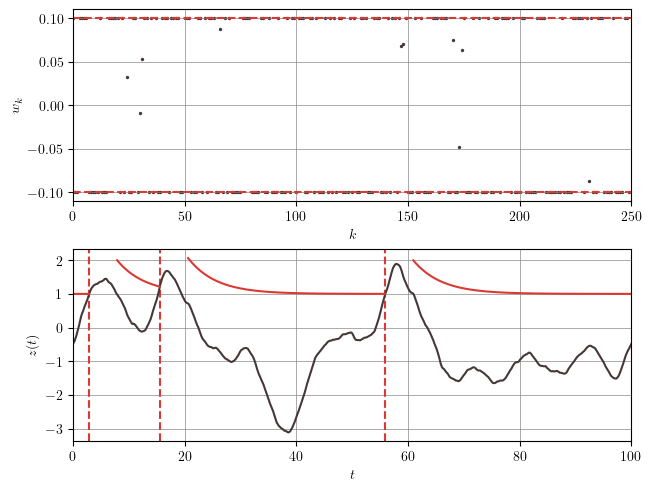

In [98]:
times = np.linspace(0, period, 1000)

fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), weights.value, s=2, c="C0", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C1")
_ = axes_template[1].plot(times, potential(times, delays, weights.value, input_spike_trains), c="C0", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

In [23]:
spike_train = compute_spike_train(wcp.value)
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(wcp.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(wcp.value))/num_inputs:.6f}")

spike train similarity: 1.000 (with a lag of 0.000)
sparsity: 0.000000
energy: 0.009759


## Bounded Weights with L2 Regularization

In [24]:
wcp = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm2(wcp))
constraints = [
    yf @ wcp == zf, 
    yl @ wcp <= zl, 
    ys @ wcp >= zs, 
    wcp >= wmin, 
    wcp <= wmax
]
prob = cp.Problem(objective, constraints)
prob.solve(solver="GUROBI");
prob.status

'optimal'

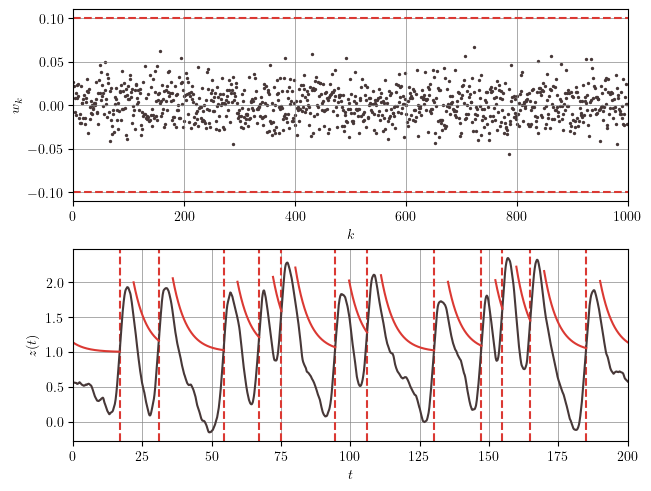

In [25]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wcp.value, s=2, c="C0", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C1")
_ = axes_template[1].plot(times, potential(times, delays, wcp.value, input_spike_trains), c="C0", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

In [26]:
spike_train = compute_spike_train(wcp.value)
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(wcp.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(wcp.value))/num_inputs:.6f}")

spike train similarity: 1.000 (with a lag of 0.000)
sparsity: 0.000000
energy: 0.000362


## Bounded Weights with L1 Regularization

In [27]:
wcp = cp.Variable(num_inputs)
objective = cp.Minimize(cp.norm1(wcp))
constraints = [
    yf @ wcp == zf, 
    yl @ wcp <= zl, 
    ys @ wcp >= zs, 
    wcp >= wmin, 
    wcp <= wmax
]
prob = cp.Problem(objective, constraints)
prob.solve(solver="GUROBI");
prob.status

'optimal'

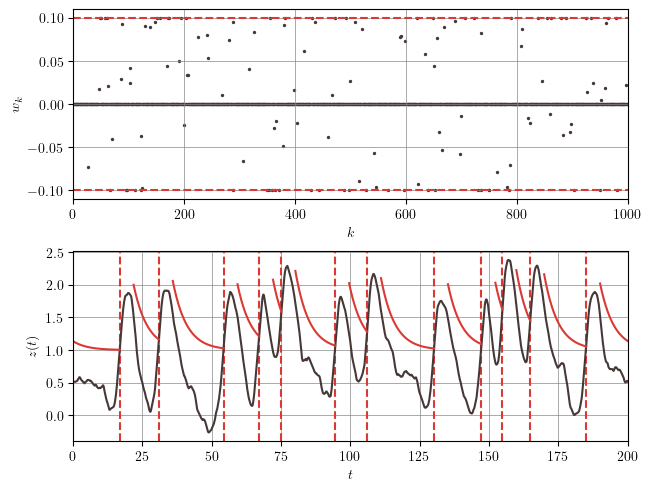

In [28]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes_template = subplots.subplots(nrows=2, ncols=1)

_ = axes_template[0].scatter(np.arange(num_inputs), wcp.value, s=2, c="C0", label=r"$w$")
_ = axes_template[0].set_xlim(0, num_inputs)
_ = axes_template[0].set_xlabel(r"$k$")
_ = axes_template[0].set_ylabel(r"$w_k$")
_ = axes_template[0].axhline(wmin, linestyle="--", c="C1")
_ = axes_template[0].axhline(wmax, linestyle="--", c="C1")

for s in target_spike_train.firing_times:
    _ = axes_template[1].axvline(s, linestyle="--", c="C1")
_ = axes_template[1].plot(times, potential(times, delays, wcp.value, input_spike_trains), c="C0", label=r"$w$")
_ = axes_template[1].plot(times, threshold(times, target_spike_train), c="C1")
_ = axes_template[1].set_xlim(0, period)
_ = axes_template[1].set_xlabel(r"$t$")
_ = axes_template[1].set_ylabel(r"$z(t)$")

In [29]:
spike_train = compute_spike_train(wcp.value)
spike_train_ = SpikeTrain(spike_train.firing_times[spike_train.firing_times > period])
corr, lag = single_channel_correlation(target_spike_train, spike_train_, eps=1e-3)

print(f"spike train similarity: {corr:.3f} (with a lag of {lag:.3f})" )
print(f"sparsity: {1 - np.count_nonzero(wcp.value)/num_inputs:.6f}")
print(f"energy: {np.sum(np.square(wcp.value))/num_inputs:.6f}")

spike train similarity: 1.000 (with a lag of 0.000)
sparsity: 0.868000
energy: 0.000858
